In [ ]:
import cv2 as cv
import numpy as np
import os

def filtrar_huellas(imagen):
    imagen_gris = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
    
    imagen_filtrada = cv.medianBlur(imagen_gris, 5)
    
    imagen_clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(imagen_filtrada)

    imagen_binaria = cv.adaptiveThreshold(
        imagen_clahe,
        255,
        cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv.THRESH_BINARY,
        11,
        10
    )

    imagen_binaria = cv.medianBlur(imagen_binaria, 3)
    
    return imagen_binaria

sample_path = "imagenes_huellas"
files = os.listdir(sample_path)

for file in files:
    dir = os.path.join(sample_path, file)
    file2 = os.listdir(dir)
    ruta = os.path.join(dir, file2[0])
    sample = cv.imread(ruta)  
    sample = filtrar_huellas(sample)

cv.imshow('Huellas', sample)
cv.waitKey(0)
cv.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = 'imagenes_huellas/crd_0820f/crd_0820s_01.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print("Error: No se pudo cargar la imagen.")
else:
    print("Imagen cargada correctamente.")
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(image)
    
    blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
    
    thresh_image = cv2.adaptiveThreshold(
        blurred_image,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11,
        10
    )
    
    inverted_image = cv2.bitwise_not(thresh_image)

    cv2.imshow('Imagen', inverted_image)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.title('Imagen Original')
    plt.imshow(image, cmap='gray')
    plt.subplot(2, 3, 2)
    plt.title('Ecualización de Histograma (CLAHE)')
    plt.imshow(equalized_image, cmap='gray')
    plt.subplot(2, 3, 3)
    plt.title('Imagen Desenfocada (Filtro Gaussiano)')
    plt.imshow(blurred_image, cmap='gray')
    plt.subplot(2, 3, 4)
    plt.title('Umbral Adaptativo')
    plt.imshow(inverted_image, cmap='gray')
    plt.show()


In [ ]:
import cv2
import os

input_folder = 'imagenes_huellas'
output_folder = 'imagenes_recortadas'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

crop_width, crop_height = 550, 550  # Ajusta el tamaño del recorte deseado

for root, dirs, files in os.walk(input_folder):
    for file in files:
        img_path = os.path.join(root, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Error al leer la imagen {img_path}")
            continue

        _, thresh = cv2.threshold(img, 225, 255, cv2.THRESH_BINARY_INV)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)

            x, y, w, h = cv2.boundingRect(largest_contour)

            center_x, center_y = x + w // 2, y + h // 2

            x_start = max(center_x - crop_width // 2, 0)
            y_start = max(center_y - crop_height // 2, 0)
            x_end = min(center_x + crop_width // 2, img.shape[1])
            y_end = min(center_y + crop_height // 2, img.shape[0])

            if (x_end - x_start) != crop_width:
                x_start = max(0, x_end - crop_width)
            if (y_end - y_start) != crop_height:
                y_start = max(0, y_end - crop_height)

            cropped_img = img[y_start:y_end, x_start:x_end]

            output_path = os.path.join(output_folder, file)
            cv2.imwrite(output_path, cropped_img)
            print(f"Imagen recortada guardada en {output_path}")


In [ ]:
import cv2
import numpy as np
import os

input_dir = 'imagenes_recortadas'
output_dir = 'imagenes_filtradas'

os.makedirs(output_dir, exist_ok=True)

def procesar_imagen(image_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error: No se pudo cargar la imagen {image_path}.")
        return
    
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(image)
    
    bilateral_filtered = cv2.bilateralFilter(equalized_image, d=9, sigmaColor=75, sigmaSpace=75)
    
    median_filtered = cv2.medianBlur(bilateral_filtered, 3)
    
    thresh_image = cv2.adaptiveThreshold(
        median_filtered,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        19,
        3
    )
    
    inverted_image = cv2.bitwise_not(thresh_image)
    
    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
    
    skeleton = np.zeros(cleaned_image.shape, np.uint8)
    img = cleaned_image.copy()
    while True:
        eroded = cv2.erode(img, None)
        temp = cv2.dilate(eroded, None)
        temp = cv2.subtract(img, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break

    cv2.imwrite(output_path, skeleton)
    print(f"Imagen procesada y guardada en {output_path}")

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.png'):
            image_path = os.path.join(root, file)
            output_path = os.path.join(output_dir, file)

            procesar_imagen(image_path, output_path)


## Codigo de david

## Estrucutra de datos imagenes

In [1]:
import os
import shutil

# Directorio de entrada
input_dir = 'imagenes_filtradas'

# Directorios de salida
output_dir = 'data'
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

# Separar huellas f para entrenamiento y s para prueba
train_images = [img for img in os.listdir(input_dir) if 'f' in img]
test_images = [img for img in os.listdir(input_dir) if 's' in img]

# Mover huellas f a la carpeta de entrenamiento
for image in train_images:
    shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'train', image))

# Mover huellas s a la carpeta de prueba
for image in test_images:
    shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'test', image))


## Aumento del numero de huellas (muestras)

In [2]:
import os
import cv2
import random
import numpy as np

def new_images(input_dir, num_images):
    images = [f for f in os.listdir(input_dir) if f.endswith('.png')]
    
    for image_name in images:
        image_path = os.path.join(input_dir, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
        
        for i in range(num_images):
            img_copy = img.copy()
            
            # Rotación aleatoria
            angle = random.randint(-360, 360)
            h, w = img_copy.shape
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            augmented_img = cv2.warpAffine(img_copy, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Escalado aleatorio
            scale_x = random.uniform(0.5, 1.5)
            scale_y = random.uniform(0.5, 1.5)
            augmented_img = cv2.resize(augmented_img, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
            
            # Traslación aleatoria
            max_shift = 10  # Máximo desplazamiento en píxeles
            tx = random.randint(-max_shift, max_shift)
            ty = random.randint(-max_shift, max_shift)
            translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
            augmented_img = cv2.warpAffine(augmented_img, translation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Guardar imagen aumentada en el mismo directorio
            output_name = f"{i}_{image_name}"
            cv2.imwrite(os.path.join(input_dir, output_name), augmented_img)

# Directorios de autenticadas
train_dir = 'data/train'
test_dir = 'data/test'

# Augmentación de imágenes autenticadas
new_images(train_dir, num_images=10)
new_images(test_dir, num_images=10)



## Etiquetamos las huellas

In [37]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformaciones
transform = transforms.Compose([
    transforms.Grayscale(),  # Asegurar escala de grises
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Transformaciones para augmentación dinámica
data_augmentation = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(degrees=360),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# Cargar datasets
train_dataset = datasets.ImageFolder('data/train', transform=data_augmentation) # Cambiar si queremos augmentación o no
test_dataset = datasets.ImageFolder('data/test', transform=data_augmentation) 

# Cargar en DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # Batch_size en funcion del tamaño de los datos
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Etiquetas automáticas
print(train_dataset.class_to_idx)  
print(test_dataset.class_to_idx, "\n")  # {'authenticated': 0, 'rejected': 1}

# Verificar tamaño de los datos
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)  
print(labels, "\n")

images, labels = next(iter(test_loader))
print(images.shape, labels.shape)  
print(labels)

{'authenticated': 0, 'rejected': 1}
{'authenticated': 0, 'rejected': 1} 

torch.Size([16, 1, 128, 128]) torch.Size([16])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0]) 

torch.Size([16, 1, 128, 128]) torch.Size([16])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## Modelo CNN
https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch


In [ ]:
#Pegarlo aqui y cambiar las dimensiones para que funcionen con las imagenes de 128x128

## Modelo CNN

In [38]:
# CNN

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Definir la arquitectura de la CNN
class FingerprintCNN(nn.Module):
    def __init__(self):
        super(FingerprintCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 1 = imágenes en escala de grises
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce tamaño a la mitad
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),  # Ajusta 16x16 si las imágenes son de 128x128
            nn.ReLU(),
            nn.Dropout(0.5),  # Ayuda a evitar el sobreajuste
            nn.Linear(256, 1),  # Una salida para clasificación binaria
            nn.Sigmoid() # Salida entre 0 y 1
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [39]:
# Configuración del dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

model = FingerprintCNN().to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss para clasificación binaria
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ciclo de entrenamiento
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Poner el modelo en modo entrenamiento
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Convertir etiquetas a float
        
        # Adelante
        outputs = model(images).squeeze(1)  # Eliminar dimensión extra de la salida
        loss = criterion(outputs, labels)
        
        # Atrás
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Usando dispositivo: cuda
Epoch 1/50, Loss: 0.6689
Epoch 2/50, Loss: 0.6248
Epoch 3/50, Loss: 0.6161
Epoch 4/50, Loss: 0.5776
Epoch 5/50, Loss: 0.5587
Epoch 6/50, Loss: 0.5568
Epoch 7/50, Loss: 0.5664
Epoch 8/50, Loss: 0.5989
Epoch 9/50, Loss: 0.5618
Epoch 10/50, Loss: 0.5686
Epoch 11/50, Loss: 0.5570
Epoch 12/50, Loss: 0.5662
Epoch 13/50, Loss: 0.5570
Epoch 14/50, Loss: 0.5479
Epoch 15/50, Loss: 0.5625
Epoch 16/50, Loss: 0.5367
Epoch 17/50, Loss: 0.5688
Epoch 18/50, Loss: 0.5623
Epoch 19/50, Loss: 0.5488
Epoch 20/50, Loss: 0.5700
Epoch 21/50, Loss: 0.5960
Epoch 22/50, Loss: 0.5830
Epoch 23/50, Loss: 0.5592
Epoch 24/50, Loss: 0.5701
Epoch 25/50, Loss: 0.5587
Epoch 26/50, Loss: 0.5672
Epoch 27/50, Loss: 0.5591
Epoch 28/50, Loss: 0.5599
Epoch 29/50, Loss: 0.5723
Epoch 30/50, Loss: 0.5524
Epoch 31/50, Loss: 0.5658
Epoch 32/50, Loss: 0.5592
Epoch 33/50, Loss: 0.5522
Epoch 34/50, Loss: 0.5758
Epoch 35/50, Loss: 0.5528
Epoch 36/50, Loss: 0.5472
Epoch 37/50, Loss: 0.5541
Epoch 38/50, Loss: 0.5

F1-Score: 0.5349
Accuracy en conjunto de prueba: 58.33%
Total de imágenes: 288, Correctas: 168, Incorrectas: 120


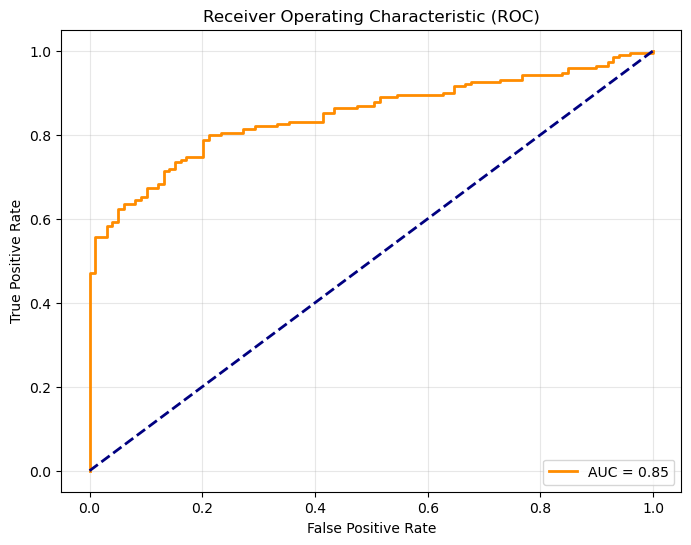

In [40]:
from sklearn.metrics import f1_score, roc_curve, auc

# Modo evaluación
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
all_probabilities = []

with torch.no_grad():  # No necesitamos gradientes para evaluación
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze(1)
        predicted = (outputs > 0.7).float()  # Umbral: salida > 0.8 es 1 (authenticated)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(outputs.cpu().numpy())

# Calcular el F1-score
f1 = f1_score(all_labels, all_predictions)
print(f"F1-Score: {f1:.4f}")

accuracy = 100 * correct / total
print(f"Accuracy en conjunto de prueba: {accuracy:.2f}%")
print(f"Total de imágenes: {total}, Correctas: {correct}, Incorrectas: {total - correct}")

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea base
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()



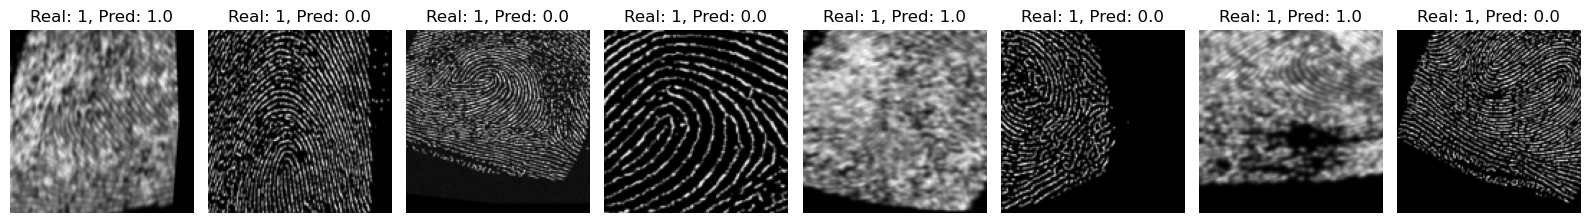

Autenticadas: 0, Rechazadas: 1

Etiquetas reales:  [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1]
Etiquetas predichas:  [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [55]:
import matplotlib.pyplot as plt
import torch

# Asegurarte de que el modelo esté en modo evaluación
model.eval()

# Obtener un lote del conjunto de entrenamiento
images, labels = next(iter(train_loader))  # Cambia `train_loader` por `test_loader` si prefieres
images, labels = images.to(device), labels.to(device)

# Realizar predicciones
with torch.no_grad():  # Desactiva el cálculo del gradiente para mayor eficiencia
    outputs = model(images).squeeze(1)  # Predicciones del modelo
    predictions = (outputs >= 0.7).float()  # Clasifica como 1 si probabilidad >= 0.7, de lo contrario 0

# Visualizar las imágenes con sus etiquetas reales y predichas
fig, axes = plt.subplots(1, 8, figsize=(16, 8))
for i, ax in enumerate(axes):
    img = images[i].cpu().squeeze().numpy()  # Convertir tensor a NumPy
    real_label = labels[i].item()  # Etiqueta real
    predicted_label = predictions[i].item()  # Etiqueta predicha
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Real: {real_label}, Pred: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Imprimir etiquetas reales y predichas para más detalle
print("Autenticadas: 0, Rechazadas: 1\n")

print("Etiquetas reales: ", labels.cpu().numpy())
print("Etiquetas predichas: ", predictions.cpu().numpy())


In [52]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Configurar el modelo en modo de evaluación
model.eval()

# Transformaciones
transform = transforms.Compose([
    transforms.Grayscale(),  # Asegurar escala de grises
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Directorio de validación
validation_dir = 'data/validation'

# Listar carpetas de validación
folders = {
    'authenticated': os.path.join(validation_dir, 'authenticated'),
    'rejected': os.path.join(validation_dir, 'rejected')
}

# Validar las imágenes de la huella 20
results = []
for label, folder in folders.items():
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path)
        
        # Preprocesar la imagen
        input_tensor = transform(image).unsqueeze(0).to(device)  # Añadir dimensión de batch
        
        # Realizar la predicción
        with torch.no_grad():
            output = model(input_tensor).item()
            prediction = "authenticated" if output <= 0.8 else "rejected"
        
        # Guardar el resultado
        results.append({
            'image': img_name,
            'label': label,
            'prediction': prediction,
            'probability': output
        })

# Mostrar resultados
for result in results:
    print(f"Imagen: {result['image']}, Etiqueta Real: {result['label']}, Predicción: {result['prediction']}, Probabilidad: {result['probability']:.4f}")


Imagen: 20s_01.png, Etiqueta Real: authenticated, Predicción: authenticated, Probabilidad: 0.3917
Imagen: 20f_01.png, Etiqueta Real: rejected, Predicción: authenticated, Probabilidad: 0.4137


## Modelo CNN preentrenado (ResNet)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Transformaciones para el dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convertir a 3 canales (los modelos preentrenados esperan RGB)
    transforms.Resize((224, 224)),  # Tamaño estándar para modelos preentrenados como ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización para modelos preentrenados
])

# Cargar datasets
train_dataset = datasets.ImageFolder('data/train', transform=transform)
test_dataset = datasets.ImageFolder('data/test', transform=transform)
validation_dataset = datasets.ImageFolder('data/validation', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Cargar un modelo preentrenado
model = models.resnet50(pretrained=True)

# Modificar la última capa para clasificación binaria
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Una salida para clasificación binaria
    nn.Sigmoid()  # Escalar la salida a [0, 1]
)

# Mover el modelo al dispositivo
model = model.to(device)

# Congelar capas iniciales (opcional)
for param in model.parameters():
    param.requires_grad = False

# Entrenar solo la última capa
for param in model.fc.parameters():
    param.requires_grad = True

# Función de pérdida y optimizador
criterion = nn.BCELoss()  # Para clasificación binaria
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Entrenamiento del modelo
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Convertir etiquetas a float
        
        # Adelante
        outputs = model(images).squeeze(1)  # Salida del modelo
        loss = criterion(outputs, labels)
        
        # Atrás
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluación del modelo
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze(1)
        predicted = (outputs > 0.8).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Precisión en el conjunto de prueba: {100 * correct / total:.2f}%")


In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Configurar el modelo en modo de evaluación
model.eval()

# Directorio de validación
validation_dir = 'data/validation'

# Listar carpetas de validación
folders = {
    'authenticated': os.path.join(validation_dir, 'authenticated'),
    'rejected': os.path.join(validation_dir, 'rejected')
}

# Validar las imágenes de la huella 20
results = []
for label, folder in folders.items():
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path)
        
        # Preprocesar la imagen
        input_tensor = transform(image).unsqueeze(0).to(device)  # Añadir dimensión de batch
        
        # Realizar la predicción
        with torch.no_grad():
            output = model(input_tensor).item()
            prediction = "authenticated" if output <= 0.5 else "rejected"
        
        # Guardar el resultado
        results.append({
            'image': img_name,
            'label': label,
            'prediction': prediction,
            'probability': output
        })

# Mostrar resultados
for result in results:
    print(f"Imagen: {result['image']}, Etiqueta Real: {result['label']}, Predicción: {result['prediction']}, Probabilidad: {result['probability']:.4f}")


## Modelo CNN con EfficientNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Transformaciones para el dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convertir imágenes a 3 canales (para modelos preentrenados)
    transforms.Resize((224, 224)),  # Tamaño estándar para EfficientNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización para ImageNet
])

# Cargar datasets
train_dataset = datasets.ImageFolder('data/train', transform=transform)
test_dataset = datasets.ImageFolder('data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Cargar EfficientNet-B0 preentrenado
model = models.efficientnet_b0(pretrained=True)

# Modificar la última capa para clasificación binaria
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 1),  # Una salida para clasificación binaria
    nn.Sigmoid()  # Escala la salida a [0, 1]
)

# Mover el modelo al dispositivo
model = model.to(device)

# Congelar capas iniciales (opcional)
for param in model.features.parameters():  # Congelar solo las capas convolucionales
    param.requires_grad = False

# Optimización y pérdida
criterion = nn.BCELoss()  # Para clasificación binaria
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # Entrenar solo la última capa

# Ciclo de entrenamiento
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Convertir etiquetas a float
        
        # Adelante
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        
        # Atrás
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluación del modelo
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze(1)
        predicted = (outputs > 0.5).long()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Precisión en el conjunto de prueba: {100 * correct / total:.2f}%")


In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Configurar el modelo en modo de evaluación
model.eval()

# Directorio de validación
validation_dir = 'data/validation'

# Listar carpetas de validación
folders = {
    'authenticated': os.path.join(validation_dir, 'authenticated'),
    'rejected': os.path.join(validation_dir, 'rejected')
}

# Validar las imágenes de la huella 20
results = []
for label, folder in folders.items():
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path)
        
        # Preprocesar la imagen, TRANSFORM DEFINIDO ARRIBA
        input_tensor = transform(image).unsqueeze(0).to(device)  # Añadir dimensión de batch
        
        # Realizar la predicción
        with torch.no_grad():
            output = model(input_tensor).item()
            prediction = "authenticated" if output <= 0.5 else "rejected"
        
        # Guardar el resultado
        results.append({
            'image': img_name,
            'label': label,
            'prediction': prediction,
            'probability': output
        })

# Mostrar resultados
for result in results:
    print(f"Imagen: {result['image']}, Etiqueta Real: {result['label']}, Predicción: {result['prediction']}, Probabilidad: {result['probability']:.4f}")
